# Introduction
Thyroid Cancer is one of the less common types of cancer, hitting the thyroid gland and can even reach other parts of the body if not treated quickly.

Our work is a study of thyroid cancer patients in the Tizi Ouzou hospital, using data from 2019 to 2023.

## Part 1 - Data
The initial dataset consisted of the details of 1290 patients diagnosed with Thyroid Cancer in the period 2019-2023. We received the data in `.xlsx` format, spreading the patients across 5 sheets each detailing a year's worth.

To say that the data was unusable is an understatement. Shifted rows, inconsistent columns, mixed categorical and numerical values, and so many more critical issues were apparent at our first analysis. Simple data manipulation with our scripts were insufficient, and when most of the other projects had most most of the effort spent in builing up their models while spending not as much in preparing their data, the majority of our work was spent solely on fixing all the issues the dataset had. Otherwise, results were impossible to obtain.

Another obstacle was the fact that most hospitals have differences in how they detail the data, and due to our inability to reach out to our data provider through either email or phone calls, we had to manage through both extensive domain research, or reaching out to other people in the medical field, with mixed results.

During and after fixing up most of the issues with the dataset, our studies have discovered bigger issues than we have anticipated. We will get into them when going through our analysis.

> Note: The `dataset.csv` is the fixed, usable dataset that was ready for preprocessing. The `original_dataset.xlsx` file is the original dataset that we received, for referencing purposes

## Part 2 - Data Preprocessing and Analysis

Once the dataset was mostly fixed, we were able to start doing our usual work with the usual cleanup and preprocessing tasks.

### Imports
These are the libraries this notebook is going to use. if you're having difficulty with executing the notebook make sure to have all modules correctly installed in your enviroment.

If you still don't have them, make sure to run `pip install -r requirements.txt`

In [71]:
import pandas as pd
import requests
from io import BytesIO
import numpy as np
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Loading the dataset

In [72]:
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

# Drop the ID column
data = data.drop(['ID'],axis=1)

print(f'Number of instances = {data.shape[0]}' )
print(f'Number of attributes = {data.shape[1]}' )
data.keys()


Number of instances = 874
Number of attributes = 30


Index(['SID', 'Sex', 'Age', 'Wilaya', 'TC Type', 'Nodule Count', 'TNM',
       'Echography', 'Cytopuncture', 'Diameter', 'Location',
       'Infected Area Count', 'ATCD', 'Family Situation', 'Discovery Method',
       'Surgery Type', 'LN Dissection', 'Post-Surgery Status', 'LN Metastasis',
       'Distant Metastasis', 'Iodine Dosage', 'Capsular Invasion',
       'Muscle Tissue Invasion', 'Vascular Embolism', 'T', 'N', 'M',
       'local_droit', 'local_gauche', 'local_isthme'],
      dtype='object')

### Handling Missing Values

In [73]:
count_na = (data.isna()).sum()

print("Empty Cells in each column")
print(count_na)

Empty Cells in each column
SID                         1
Sex                         6
Age                         2
Wilaya                      3
TC Type                     7
Nodule Count              161
TNM                        13
Echography                145
Cytopuncture                0
Diameter                   49
Location                   41
Infected Area Count       325
ATCD                        2
Family Situation            1
Discovery Method           13
Surgery Type               10
LN Dissection              53
Post-Surgery Status       106
LN Metastasis              68
Distant Metastasis         71
Iodine Dosage             415
Capsular Invasion          64
Muscle Tissue Invasion     66
Vascular Embolism          69
T                          13
N                          14
M                          13
local_droit                41
local_gauche               41
local_isthme               41
dtype: int64


*Numerical Data:*

We will handle the missing numerical data by filling empty cells with the median value of that column 

In [74]:
data["Nodule Count"] = data["Nodule Count"].fillna(data["Nodule Count"].median())
data["Diameter"] = data["Diameter"].fillna(data["Diameter"].median())
data["Age"] = data["Age"].fillna(data["Age"].median())

*Categorical Data:*

Currently left as NaN

### Outliers
Outliers are data instances with characteristics that are considerably different from the rest of the dataset. 

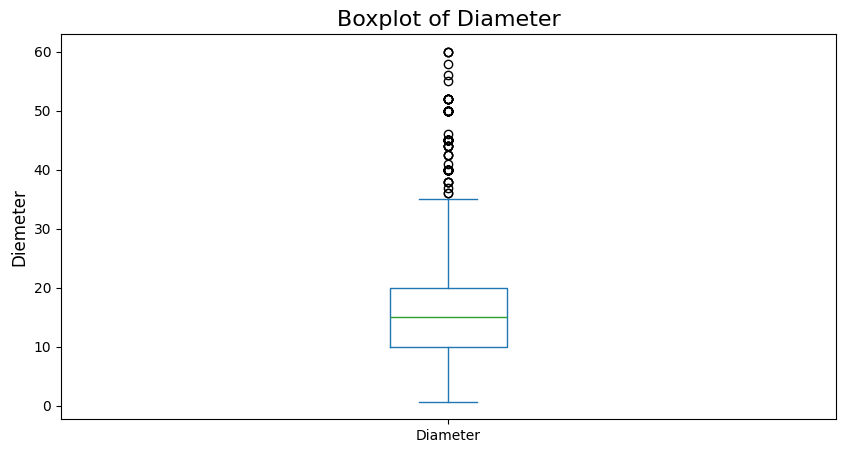

In [91]:
plt.figure(figsize=(10, 5))  
data['Diameter'].plot(kind='box', figsize=(10, 5))

plt.title("Boxplot of Diameter", fontsize=16)
plt.ylabel("Diemeter", fontsize=12)

plt.show()

The boxplots suggest that only 8 instances have abnormally high Diemeter length. To discard the outliers, we can compute the Z-score and remove those instances containing a diameter with abnormally high or low Z-score (e.g., if Z > 3 or Z <= -3).

In [76]:
Z = (data['Diameter']-data['Diameter'].mean())/data['Diameter'].std()

In [77]:
print( f'Number of rows before discarding outliers = {data.__len__()}' )

data = data[(Z <= 3) & (Z >= -3)]
print( f'Number of rows before discarding outliers = {data.__len__()}' )

Number of rows before discarding outliers = 874
Number of rows before discarding outliers = 853


### Duplicates


In [78]:
dups = data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


With no duplicates in the data, no need to handle them


### Unify Values Names

In [79]:
data['Echography'].value_counts()

Echography
tirads 5    352
tirads 4    221
tirads 3    110
tirads 6     20
tirads 2      3
tirads 1      3
Name: count, dtype: int64

### Visualize Correlation
we'll visualize correlation between the severity of the cancer anfd the diamter of the nodules

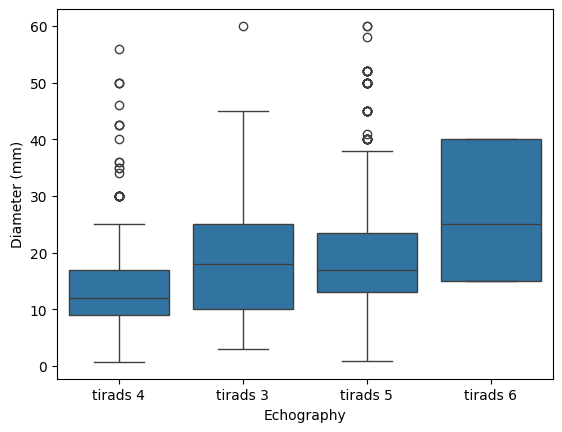

In [80]:
# Visualize relationship between price and room_type
# choose the data where at least 10 valures of Echography type
category_counts = data["Echography"].value_counts()
valid_categories = category_counts[category_counts >= 10].index
filtered_data = data[data["Echography"].isin(valid_categories)]

sns.boxplot(x = 'Echography', y = 'Diameter', data = filtered_data)
plt.xlabel('Echography')
plt.ylabel('Diameter (mm)')
plt.show() 

Although some noise in the data, it seems that the bigger the severity of the cancer the bigger the diameter

### Correlation Analysis

In [81]:
data['Sex'].value_counts()

Sex
F    712
H    135
Name: count, dtype: int64

We'll analyse correlation between some attributes

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
C:\Users\almaj\AppData\Local\Temp\ipykernel_28864\740473610.py:5: SyntaxWarning: invalid escape sequence '\d'
  data_copy['Echography'] = data_copy['Echography'].str.extract('(\d+)').astype(int)


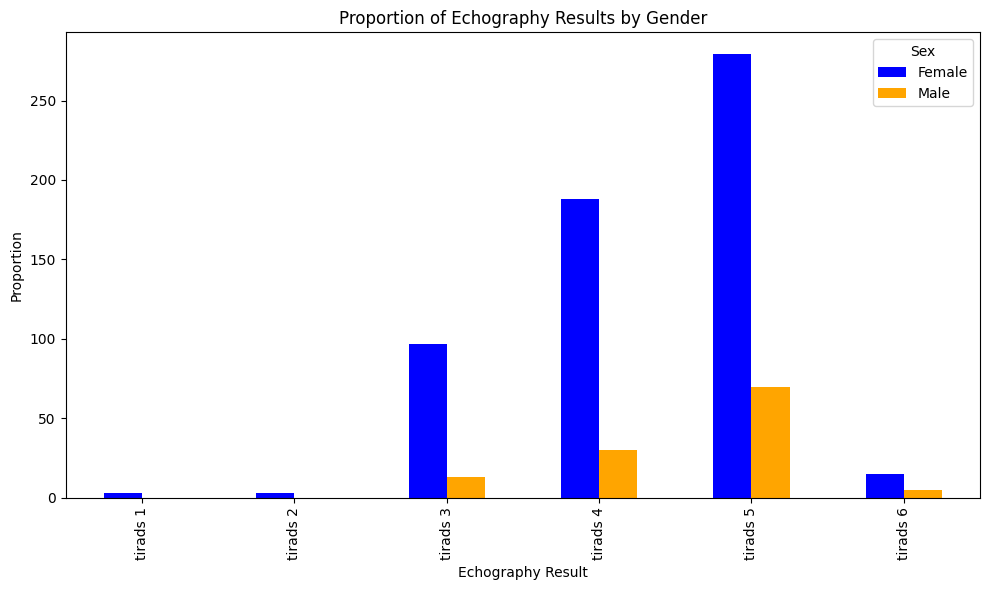


Cross-tabulation between Sex and Echography:
Echography  1  2    3    4    5   6  Total
Sex                                       
F           3  3   97  188  279  15    585
H           0  0   13   30   70   5    118
Total       3  3  110  218  349  20    703

Chi-Square Test Results:
Chi2 Statistic: 8.2216047305529
P-value: 0.14443804168432134
Degrees of Freedom: 5
Expected frequencies:
[[  2.49644381   2.49644381  91.53627312 181.40825036 290.41963016
   16.64295875]
 [  0.50355619   0.50355619  18.46372688  36.59174964  58.58036984
    3.35704125]]

There is no statistically significant relationship between Sex and Echography (p >= 0.1).


In [82]:
data_copy = data.copy()

data_copy['Echography'] = data_copy['Echography'].replace('nan', 'tirads 0')
data_copy['Echography'] = data_copy['Echography'].fillna('tirads 0')
data_copy['Echography'] = data_copy['Echography'].str.extract('(\d+)').astype(int)

data_copy = data_copy[data_copy['Echography'] != 0]

X = data_copy[['Sex', 'Echography']]  

data_copy = data_copy[~data_copy['Sex'].isin(['FF', 'nan'])]

echography_sex_props = data.groupby(['Echography', 'Sex']).size().unstack()
fig, ax = plt.subplots(figsize=(10, 6))
echography_sex_props.plot(kind='bar', ax=ax, color=['blue', 'orange'])
ax.set_title('Proportion of Echography Results by Gender')
ax.set_xlabel('Echography Result')
ax.set_ylabel('Proportion')
ax.legend(title='Sex', labels=['Female', 'Male'])
plt.tight_layout()
plt.show()

cross_tab = pd.crosstab(data_copy['Sex'], data_copy['Echography'], margins=True, margins_name="Total")
print("\nCross-tabulation between Sex and Echography:")
print(cross_tab)

chi2, p, dof, expected = chi2_contingency(cross_tab.iloc[:-1, :-1])  
print("\nChi-Square Test Results:")
print(f"Chi2 Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected frequencies:")
print(expected)

if p < 0.1:
    print("\nThere is a statistically significant relationship between Sex and Echography (p < 0.1).")
else:
    print("\nThere is no statistically significant relationship between Sex and Echography (p >= 0.1).")

The graph clearly suggests that females consist of most of the thyroid cancer patients especially at later stages, which aligns with medical literature and information.

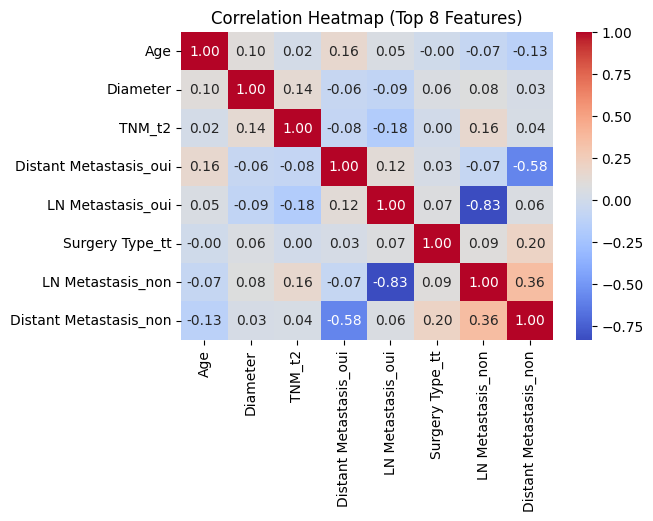

In [83]:
# Convert categorical columns using One-Hot Encoding
categorical_columns = [
    "Sex", "Wilaya", "TC Type", "Echography", "Cytopuncture", "Location", "Infected Area Count", "ATCD", 
    "Family Situation", "Discovery Method", "Surgery Type", "LN Dissection", "Post-Surgery Status", 
    "LN Metastasis", "Distant Metastasis", "Iodine Dosage", "Capsular Invasion", "Muscle Tissue Invasion", 
    "Vascular Embolism", "TNM"  
]

for col in categorical_columns:
    data[col] = data[col].astype(str)


data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
selected_features = ["Age", "Diameter", "TNM_t2", "Distant Metastasis_oui", 
    "LN Metastasis_oui", "Surgery Type_tt", "LN Metastasis_non", "Distant Metastasis_non" ]

correlation_matrix = data_encoded[selected_features].corr()

plt.figure(figsize=(6, 4)) 
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Top 8 Features)")
plt.show()

The most notable relationships are between Surgery Type, LN Metastasis, and Distant Metastasis (correlations around 0.43-0.44). These stronger correlations make clinical sense, as the presence of metastases often influences surgical decision-making. It's interesting that patient age, tumor diameter, and imaging findings (Echography_tirads) show very weak correlations with other variables, suggesting they may be independently important factors in clinical assessment rather than being strongly linked to other disease characteristics.

## Part 3 - Model Analysis and Building

After this analysis, we attempted multiple approaches with building different models for different purposes. Most Thyroid Cancer models are Classification models, but we had to try different approaches due to reasons that will be apparent later.

### Association Rules
first we try uncover the relation between the surgery type and the cancer not spreading

In [84]:
categorical_data = data[["Echography", "Cytopuncture", "Surgery Type","TNM", "Capsular Invasion", "LN Metastasis"]]

categorical_data = pd.get_dummies(categorical_data)

frequent_itemsets = apriori(categorical_data, min_support=0.5, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

print(rules[["antecedents", "consequents", "support", "confidence", "lift"]])

                                   antecedents  \
0                      (Capsular Invasion_non)   
1                            (Surgery Type_tt)   
2                          (LN Metastasis_non)   
3                            (Surgery Type_tt)   
4                          (LN Metastasis_non)   
5                      (Capsular Invasion_non)   
6   (LN Metastasis_non, Capsular Invasion_non)   
7         (LN Metastasis_non, Surgery Type_tt)   
8     (Capsular Invasion_non, Surgery Type_tt)   
9                          (LN Metastasis_non)   
10                     (Capsular Invasion_non)   

                                 consequents   support  confidence      lift  
0                          (Surgery Type_tt)  0.786635    0.988218  1.010731  
1                    (Capsular Invasion_non)  0.786635    0.804556  1.010731  
2                          (Surgery Type_tt)  0.654162    0.987611  1.010110  
3                        (LN Metastasis_non)  0.654162    0.669065  1.010110  
4   

Although The results seem to confirm at first that when the disease is not spread, the operation is performed. But we have to consider the following 

In [85]:
print(f"Total Surgeries Proportion of all Surgery Types: { data["Surgery Type"].value_counts()["tt"]/data["Surgery Type"].value_counts().sum()}")
print(f"Absence of Capsular Invasion: { data["Capsular Invasion"].value_counts()["non"]/data["Capsular Invasion"].value_counts().sum()}")
print(f"Absence of LN Metastasis: { data["LN Metastasis"].value_counts()["non"]/data["LN Metastasis"].value_counts().sum()}")

Total Surgeries Proportion of all Surgery Types: 0.977725674091442
Absence of Capsular Invasion: 0.7960140679953107
Absence of LN Metastasis: 0.6623681125439624


These Values indicate that the association rules are high because the proportion of these values in the dataset is high. So we disregard the obtained rules.

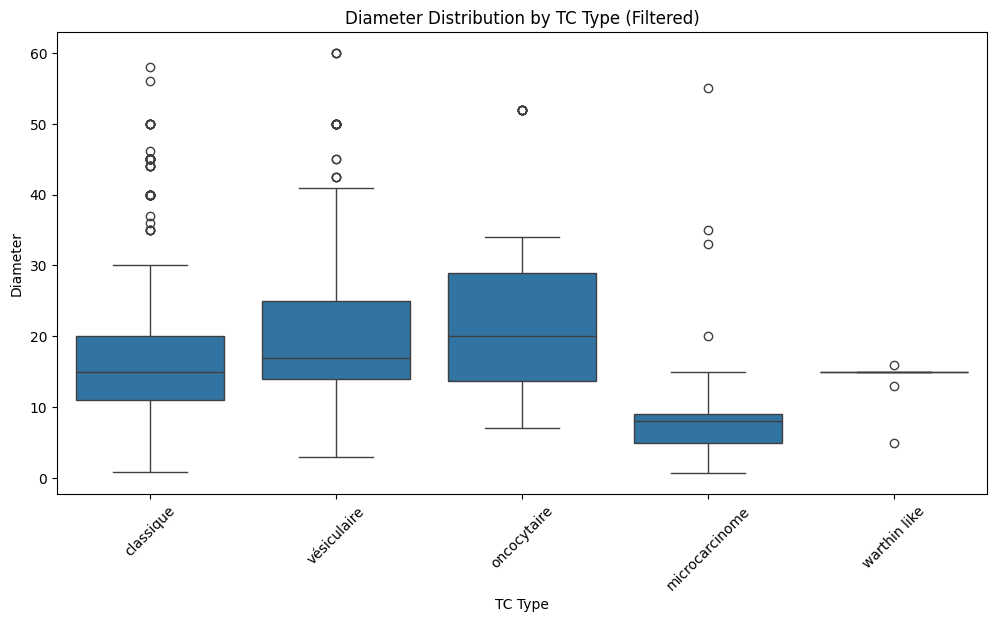

In [86]:
tc_type_counts = data["TC Type"].value_counts()

valid_tc_types = tc_type_counts[tc_type_counts >= 10].index

data_filtered = data[data["TC Type"].isin(valid_tc_types)]

data_encoded = pd.get_dummies(data_filtered, columns=["TC Type"], drop_first=True)

plt.figure(figsize=(12, 6))
sns.boxplot(x="TC Type", y="Diameter", data=data_filtered)
plt.title("Diameter Distribution by TC Type (Filtered)")
plt.xlabel("TC Type")
plt.ylabel("Diameter")
plt.xticks(rotation=45) 
plt.show()

This Suggests that the type microcarinome has less diameter than others.

In fact this is true because microcarinome normally have a diameter less than one 

Read More: https://pmc.ncbi.nlm.nih.gov/articles/PMC6768151/

### Clustering


We test If there is correlation between the age and the risk of the cancer 

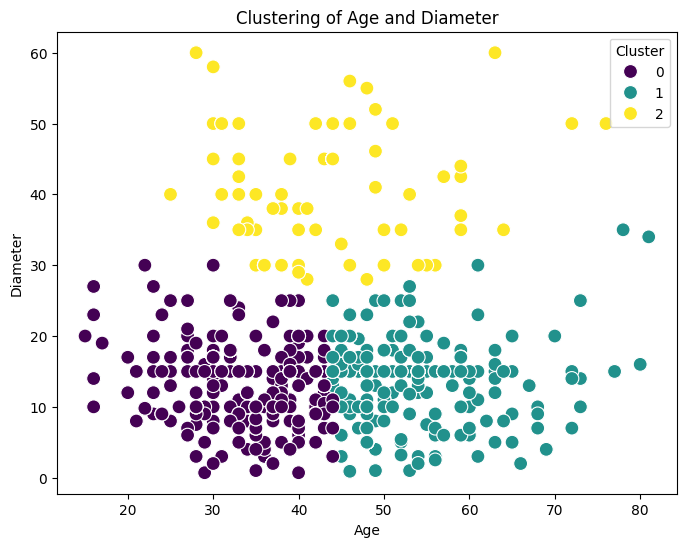

In [87]:
data_copy = data.copy()

X = data_copy[['Age', 'Diameter']]

kmeans = KMeans(n_clusters=3, random_state=42)
data_copy['Cluster'] = kmeans.fit_predict(X)


plt.figure(figsize=(8, 6))
sns.scatterplot(data=data_copy, x='Age', y='Diameter', hue='Cluster', palette='viridis', s=100, marker='o')
plt.title("Clustering of Age and Diameter")
plt.xlabel("Age")
plt.ylabel("Diameter")
plt.legend(title="Cluster")
plt.show()


This suggests that no relation exists between the age and diameter of the TCP (Which is a bit odd)

### Classification

Now we could have went on and classified based on whether patients have cancer or not, but our dataset consists of only patients who were indeed diagnose with Thyroid Cancer. Our attempts at contacting the dataset provider for more data concerning normal patients with no cancer were not successful, so we had to find other target attributes, with varying success.


We try to predict the post surgery status instead, using different features

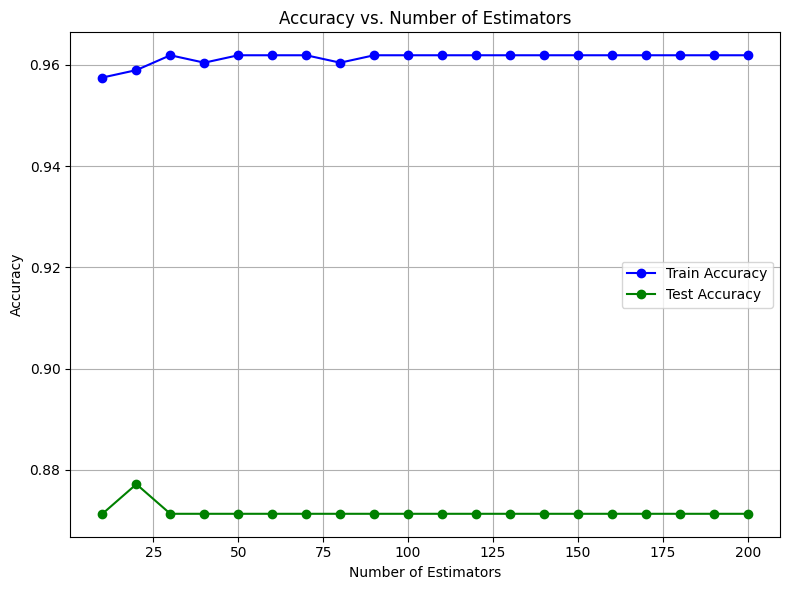

F1 Score: 0.8632


In [88]:


features = ["Diameter", "Infected Area Count", "Echography", "TNM"]

data_filtered = data.dropna(subset=features + ["Post-Surgery Status"])

y = data_filtered["Post-Surgery Status"]

X = data_filtered[features]
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

train_accuracies = []
test_accuracies = []

n_estimators_range = range(10, 201, 10) 

for n in n_estimators_range:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_accuracies.append(accuracy_score(y_train, y_train_pred))
    test_accuracies.append(accuracy_score(y_test, y_test_pred))
    


train_f1 = f1_score(y_train, y_train_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
plt.figure(figsize=(8, 6))

plt.plot(n_estimators_range, train_accuracies, marker='o', label='Train Accuracy', color='blue')
plt.plot(n_estimators_range, test_accuracies, marker='o', label='Test Accuracy', color='green')
plt.title("Accuracy vs. Number of Estimators")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
print(f"F1 Score: {test_f1:.4f}")


Both the accuracy and the f1 score a high, indicating a good model prediction

we try and generate a prediction from the model

In [89]:
new_data = [[40, 2.5, 'bifocal', 'tirads 6', 't2']]  

new_data_df = pd.DataFrame(new_data, columns=["Age", "Diameter", "Infected Area Count", "Echography", "TNM"])

new_data_encoded = pd.get_dummies(new_data_df, drop_first=True)

new_data_encoded = new_data_encoded.reindex(columns=X.columns, fill_value=0)

new_prediction = model.predict(new_data_encoded)

print(f"Prediction for new data: {new_prediction[0]}")

Prediction for new data: simples


### Anomally Detection

we try to detect anomalies concerning both the Diameter and Age


Anomaly Count:
Anomaly
 1    848
-1      4
Name: count, dtype: int64


C:\Users\almaj\AppData\Local\Temp\ipykernel_28864\2101177585.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered[categorical_cols] = data_filtered[categorical_cols].astype(str)
C:\Users\almaj\AppData\Local\Temp\ipykernel_28864\2101177585.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered["Anomaly"] = iso_forest.fit_predict(features_scaled)


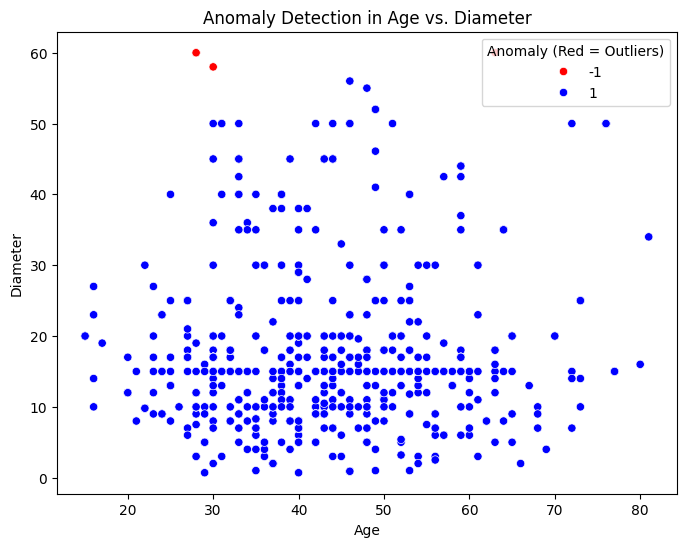


Detected Anomalies:
        SID Sex   Age Wilaya      TC Type  Nodule Count  TNM Echography  \
103  124/23   H  30.0  alger    classique           1.0   t3   tirads 5   
407  029/22   H  28.0  alger  vésiculaire           1.0  t3a   tirads 5   
608  229/22   H  28.0  alger  vésiculaire           2.0   t3   tirads 3   
857  220/20   H  63.0  msila  vésiculaire           1.0  t3a   tirads 5   

    Cytopuncture  Diameter  ... Capsular Invasion Muscle Tissue Invasion  \
103       nodule      58.0  ...               non                    non   
407       goitre      60.0  ...               non                    non   
608       goitre      60.0  ...               non                    non   
857       goitre      60.0  ...               non                    non   

    Vascular Embolism   T  N    M local_droit local_gauche local_isthme  \
103               non   3  0  0.0         0.0          1.0          0.0   
407               non  3a  0  0.0         1.0          0.0          0.0 

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler


categorical_cols = ["SID", "Sex", "Wilaya", "TC Type", "TNM", "Echography", "Cytopuncture", "Location", 
                    "Infected Area Count", "ATCD", "Family Situation", "Discovery Method", 
                    "Surgery Type", "LN Dissection", "Post-Surgery Status", "LN Metastasis", 
                    "Distant Metastasis", "Iodine Dosage", "Capsular Invasion", 
                    "Muscle Tissue Invasion", "Vascular Embolism"]

numerical_cols = ["Age", "Nodule Count", "Diameter"]

data_filtered = data.dropna(subset=numerical_cols + categorical_cols)

data_filtered[categorical_cols] = data_filtered[categorical_cols].astype(str)

data_encoded = pd.get_dummies(data_filtered, columns=categorical_cols, drop_first=True)

scaler = StandardScaler()
data_encoded[numerical_cols] = scaler.fit_transform(data_encoded[numerical_cols])
features_for_anomaly = data_filtered[['Age', 'Diameter']]
features_scaled = StandardScaler().fit_transform(features_for_anomaly)

iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
data_filtered["Anomaly"] = iso_forest.fit_predict(features_scaled)

print("\nAnomaly Count:")
print(data_filtered["Anomaly"].value_counts())

plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_filtered["Age"], y=data_filtered["Diameter"], hue=data_filtered["Anomaly"], palette={1: "blue", -1: "red"})
plt.title("Anomaly Detection in Age vs. Diameter")
plt.xlabel("Age")
plt.ylabel("Diameter")
plt.legend(title="Anomaly (Red = Outliers)")
plt.show()

anomalies = data_filtered[data_filtered["Anomaly"] == -1]
print("\nDetected Anomalies:")
print(anomalies)

# Conclusion
- Predictive Models (like Random Forest) offer a valuable tool for forecasting Post-Surgery Status, guiding medical professionals in pre-surgery decision-making.
- Due to the dataset being dominated by single valued attributes, useful information was hard to obtain
- As this problem is usually Classification based, other approaches were hard to use.

# Appendix A: Various Graphs

The graphs below demonstrate some properties in the datasete which weren't praticularly useful, but kept for reference.

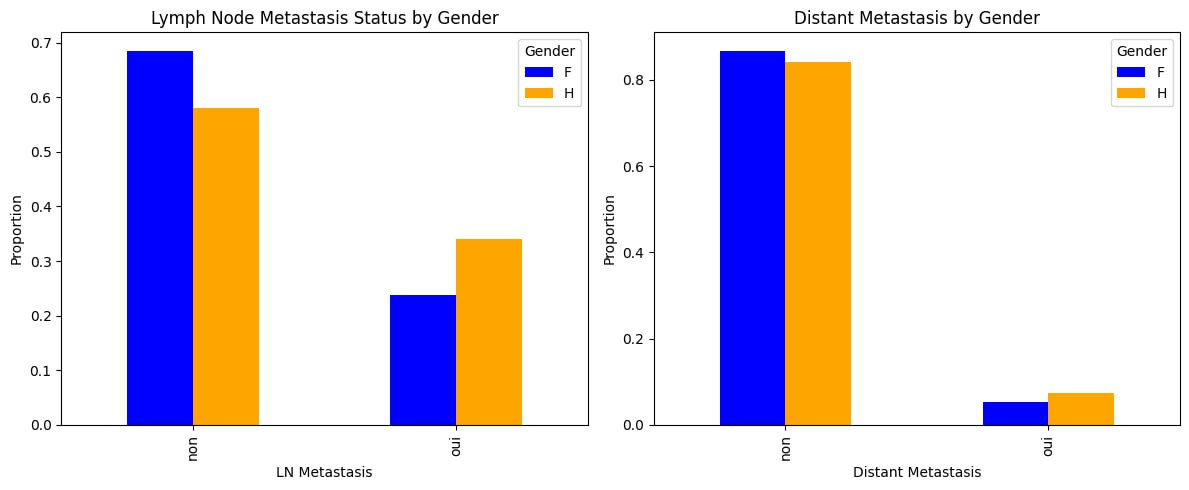
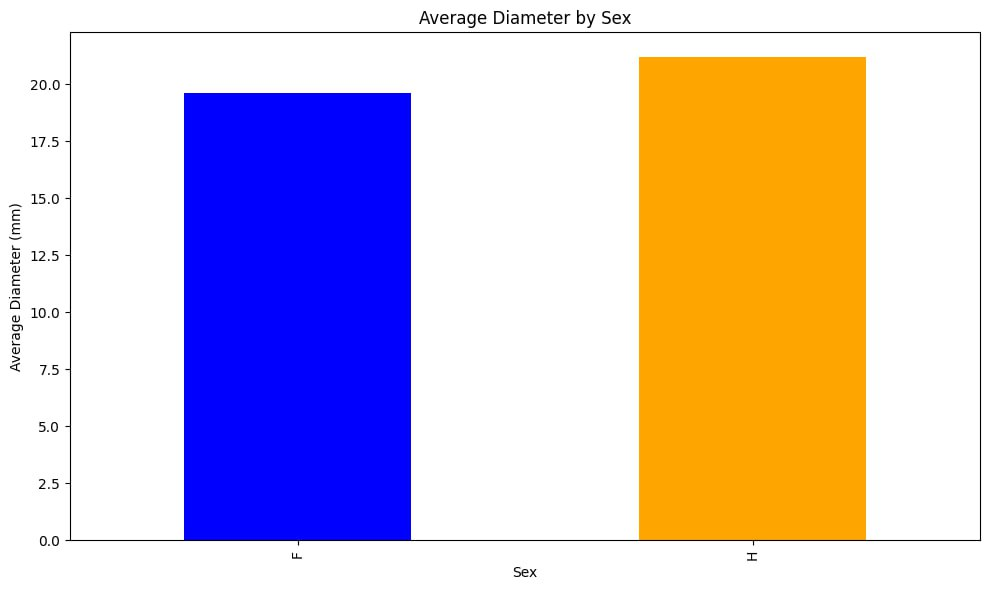
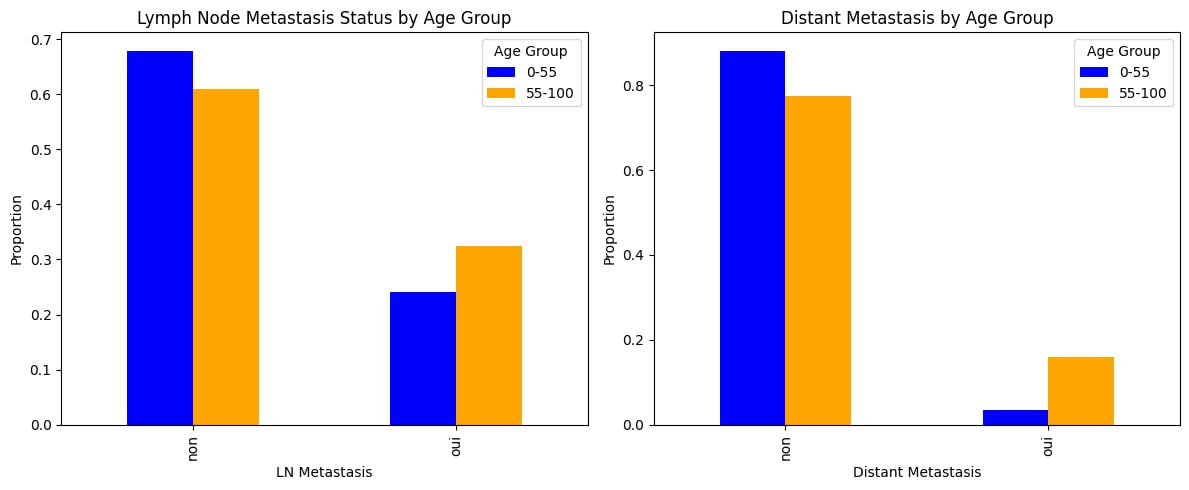
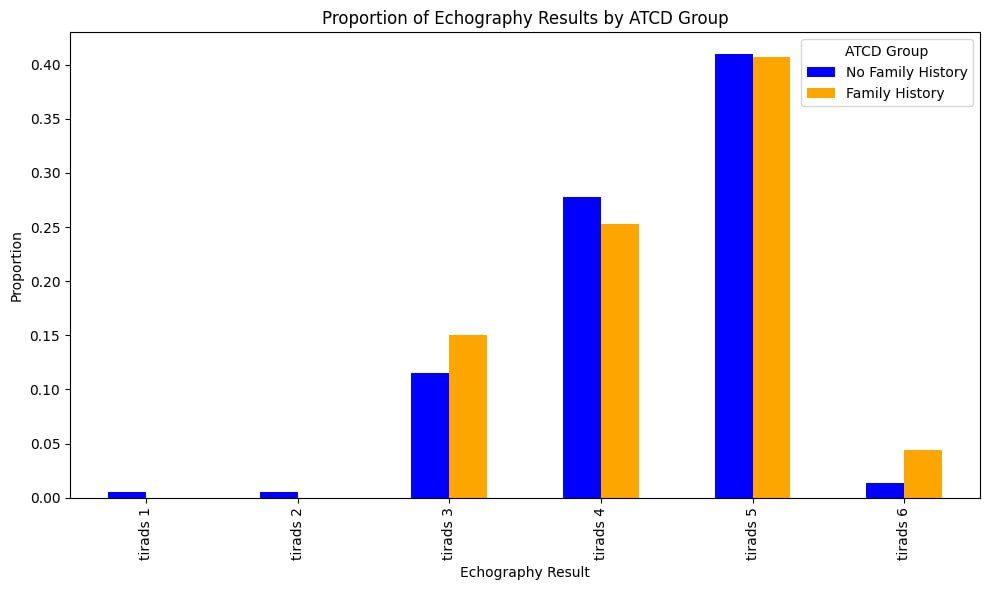
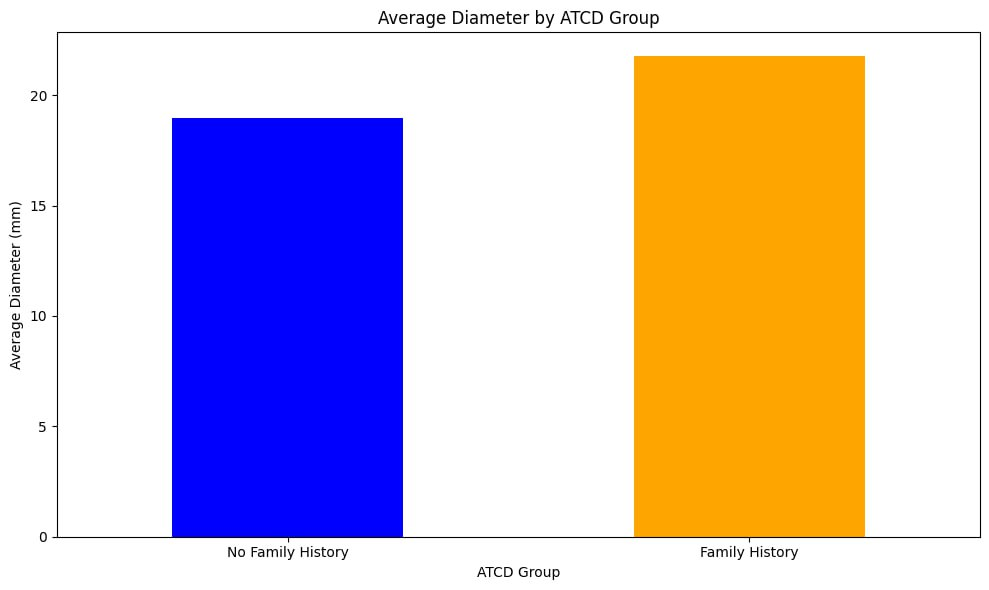

# Appendix B: Useful graphs

These graphs aided in our analysis of the dataset

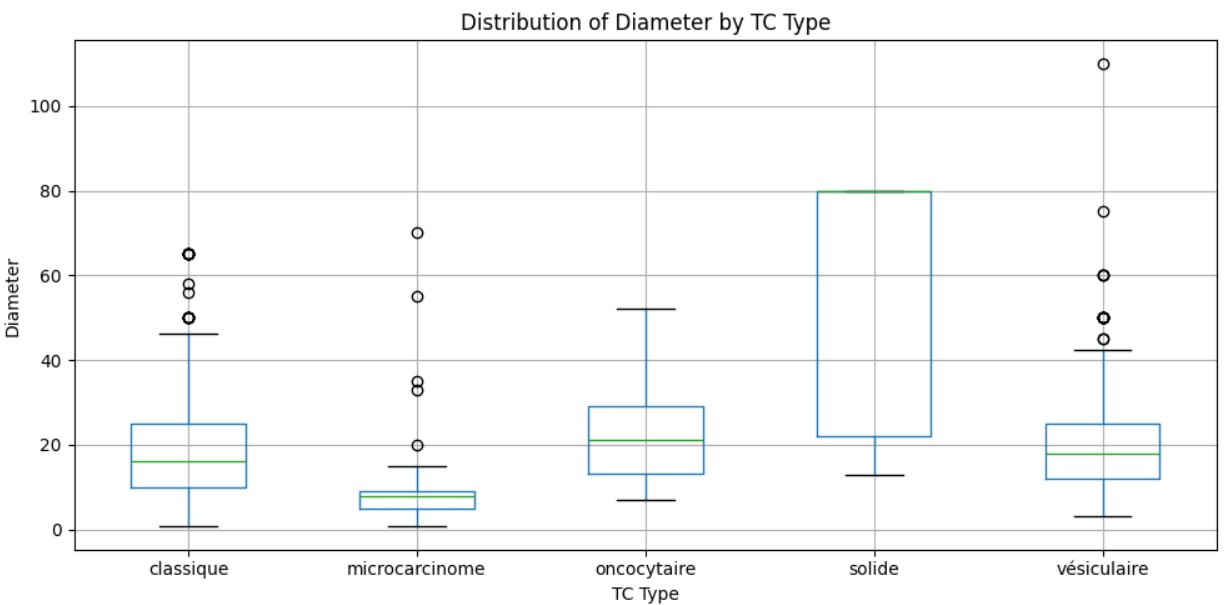
##### As you might notice micocarcinome has significantly lower diameter than other types which alligns with the literature

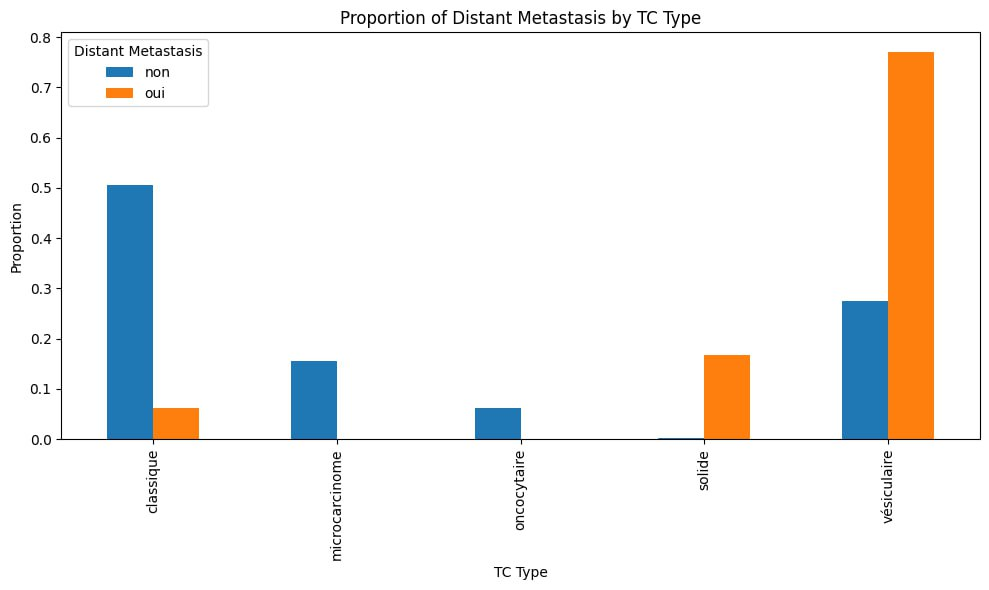
##### Although "non" is dominant in distant metastasis for all attributes but for vesculair oui was more dominant